In [1]:
# Data packages
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

from model.rnn import GRUDecoder
from model.encoders import CustomExcelFormer
from data_processing.pipeline import encoding_pipeline, get_generic_name


import matplotlib.pyplot as plt
from model.utils import get_device
from model.dataset import PretrainingDataset
from model.dataset import FinetuningDataset


In [2]:
device = get_device()

Using MPS (Metal Performance Shaders) device


# Read the data

Right now the notebook is set to work with fake data. This can be changed once the pipeline works.

The data is stored as a Dict[person_id, Sequences] where Sequences is a Dict[year, survery_wave_response]

In [3]:
def make_data(n_cols: int):
    # read in data and prepare transformations
    data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
    targets_df = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
    codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

    importance = pd.read_csv('features_importance_all.csv')
    custom_pairs = importance.feature.map(lambda x: get_generic_name(x)).unique()[:n_cols]
    "Unique columns count: %s" %len(set(custom_pairs))

    # check if sequences have been preprocessed (saves time)
    sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs, importance=importance, use_codebook=True)
    pretrain_dataset = PretrainingDataset(sequences)
    return sequences, pretrain_dataset

In [4]:
class DataClass:
    def __init__(self,
                 data_path: str = "data/training_data/PreFer_train_data.csv",
                 targets_path: str = 'data/training_data/PreFer_train_outcome.csv',
                 codebook_path: str = 'data/codebooks/PreFer_codebook.csv',
                 importance_path: str = 'features_importance_all.csv') -> None:
        self.data = pd.read_csv(data_path, low_memory=False)
        self.targets = pd.read_csv(targets_path)
        self.codebook = pd.read_csv(codebook_path)
        self.col_importance = pd.read_csv(importance_path)
    def make_sequences(self, n_cols: int, use_codebook: bool = True):
        custom_pairs = self.col_importance.feature.map(lambda x: get_generic_name(x)).unique()[:n_cols]
        self.sequences = encoding_pipeline(self.data, self.codebook, 
                                           custom_pairs=custom_pairs, 
                                           importance=self.col_importance, 
                                           use_codebook=use_codebook)
    def make_pretraining(self):
        self.pretrain_dataset = PretrainingDataset(self.sequences)
        self.seq_len = self.pretrain_dataset.get_seq_len()
        self.vocab_size = self.pretrain_dataset.get_vocab_size()
    def make_finetuning(self, batch_size, test_size: float = 0.2, val_size: float = 0.2):
        targets = self.targets[self.targets.new_child.notna()]
        train_person_ids, test_person_ids = train_test_split(targets['nomem_encr'], test_size=test_size, random_state=42)
        train_person_ids, val_person_ids = train_test_split(train_person_ids, test_size=val_size, random_state=42)
        rnn_data = {person_id: (
                torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
                torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
                )
                for person_id, wave_responses in self.sequences.items()
                }

        # split data based on the splits made for the target
        train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
        val_data = {person_id: rnn_data[person_id] for person_id in val_person_ids}
        test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}

        self.train_dataset = FinetuningDataset(train_data, targets = targets)
        self.val_dataset = FinetuningDataset(val_data, targets = targets)
        self.test_dataset = FinetuningDataset(test_data, targets = targets)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader  = DataLoader(self.test_dataset,  batch_size=batch_size)





## SETUP

In [5]:
data = DataClass()

In [6]:
data.make_sequences(n_cols=50)
data.make_pretraining()
data.make_finetuning(batch_size=16)

/Users/carlomarx/Documents/GitHub/fertility-prediction-challenge/data_processing/pipeline.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


In [7]:
### Initialization of the Autoencoder 
#ENCODING_SIZE = 64
BATCH_SIZE = 16
HIDDEN_SIZE = 64
ENCODING_SIZE = 64
NUM_HEADS = 4
NUM_LAYERS = 3
NUM_EPOCHS = 10
DETECT_ANOMALY = False
SEQ_LEN = data.seq_len
VOCAB_SIZE = data.vocab_size

LR = 1e-3

assert HIDDEN_SIZE % NUM_HEADS == 0, "Check that the hidden size is divisible"
print(SEQ_LEN)

49


# Experimental Encoder (Only)

# Train the RNN

First we need to create Dataset class that can hold both the target (stored in a pd.DataFrame) and the sequences.

The sequences will be of dimension 14 x encoding_dimension, because we have 14 years of surveys.

I have created some code for getting the data into the right format, but it might not be useful.

## Regarding masks
Right now the masking is done already in the encoding. I haven't found exactly where Mikkel implemented this.
So for now, assume that nothing is padded, and then we'll figure it out with Mikkel.

In [8]:
encoder = CustomExcelFormer(vocab_size=VOCAB_SIZE, 
                            hidden_size=HIDDEN_SIZE, 
                            out_size=ENCODING_SIZE,
                            n_years=14,
                            num_heads=NUM_HEADS,
                            num_layers=NUM_LAYERS, 
                            num_classes=2,
                            sequence_len=SEQ_LEN, 
                            aium_dropout=0.3,
                            diam_dropout=0.2,
                            residual_dropout=0.1,
                            embedding_dropout=0.1,
                            mixup=None,
                            beta=0.2).to(device)

Embedding Layer with the Dropout


In [9]:
decoder = GRUDecoder(
    input_size=ENCODING_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=3,
    max_seq_len=14,
    dropout=0.15,
    bidirectional=True,
    with_attention = True
).to(device)


# Define loss function and optimizer for RNN
ft_loss = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1/0.2]).to(device))
ft_optimizer = torch.optim.RAdam(list(decoder.parameters()) + list(encoder.parameters()) , lr=LR, weight_decay=1e-2, decoupled_weight_decay=True)
ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = NUM_EPOCHS, eta_min = 1e-4, last_epoch = -1)

# Training loop
decoder.train()
encoder.train()
print("Ready!")

/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/carlomarx/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready!


In [10]:
def run_validation():
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode.=
    decoder.eval()
    encoder.eval()
    for batch in data.val_dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings, _ = encoder(input_year, input_seq)
        encodings = encodings.view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()


        # Forward pass
        xx = decoder(encodings, mask)
        outputs = F.sigmoid(xx).flatten()
        loss = ft_loss(xx.flatten(), labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())

    # Concatenate all the batches
    probs = torch.tensor(preds).flatten()
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), probs.cpu().numpy() > 0.5, average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    print(f"-- mAP Score: {map_roc:.4f} -- f1-score: {f1:.3f}")
    decoder.train()
    encoder.train()

In [11]:
loop_object  = tqdm(enumerate(data.train_dataloader))

length = 0
pos = 0
for i, batch in loop_object :        
        inputs, labels = batch
        length +=labels.shape[0]
        pos += (labels == 1).sum()

pos/length


40it [00:00, 933.60it/s]


tensor(0.1918)

In [12]:
loss_per_epoch = []
for epoch in range(NUM_EPOCHS):
    # print(epoch)
    loss_per_step = []
    loop_object  = tqdm(enumerate(data.train_dataloader), desc=f"Epochs {epoch}")
    for i, batch in loop_object :        
        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)
        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings, _ = encoder(input_year, input_seq)#, y=labels.unsqueeze(-1).expand(-1, 14).reshape(-1), mixup_encoded=True)
        encodings = encodings.view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask=mask).flatten()
        outputs = F.sigmoid(xx)

        loss = ft_loss(xx, labels)  
        loss_per_step.append(loss.detach().cpu().numpy())
        loop_object.set_postfix_str("mean loss: %.3f"%np.mean(loss_per_step[-100:]))

        loss.backward()
        ft_optimizer.step()
    # On epoch end
    loss_per_epoch.append(np.mean(loss_per_step))
    ft_scheduler.step()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss_per_epoch[-1]:.4f}")
    run_validation()
    

Epochs 0: 40it [00:08,  4.66it/s, mean loss: 1.229]


Epoch 1/10, Loss: 1.2294
-- mAP Score: 0.5312 -- f1-score: 0.305


Epochs 1: 40it [00:05,  6.71it/s, mean loss: 1.089]


Epoch 2/10, Loss: 1.0890
-- mAP Score: 0.6094 -- f1-score: 0.592


Epochs 2: 40it [00:05,  6.80it/s, mean loss: 0.840]


Epoch 3/10, Loss: 0.8400
-- mAP Score: 0.6606 -- f1-score: 0.571


Epochs 3: 40it [00:05,  6.70it/s, mean loss: 0.740]


Epoch 4/10, Loss: 0.7400
-- mAP Score: 0.7212 -- f1-score: 0.713


Epochs 4: 40it [00:05,  6.77it/s, mean loss: 0.618]


Epoch 5/10, Loss: 0.6176
-- mAP Score: 0.7617 -- f1-score: 0.759


Epochs 5: 40it [00:05,  6.83it/s, mean loss: 0.558]


Epoch 6/10, Loss: 0.5579
-- mAP Score: 0.7660 -- f1-score: 0.738


Epochs 6: 40it [00:05,  6.79it/s, mean loss: 0.532]


Epoch 7/10, Loss: 0.5319
-- mAP Score: 0.7712 -- f1-score: 0.720


Epochs 7: 40it [00:05,  6.67it/s, mean loss: 0.461]


Epoch 8/10, Loss: 0.4612
-- mAP Score: 0.7849 -- f1-score: 0.700


Epochs 8: 40it [00:05,  6.75it/s, mean loss: 0.468]


Epoch 9/10, Loss: 0.4684
-- mAP Score: 0.7741 -- f1-score: 0.713


Epochs 9: 40it [00:05,  6.77it/s, mean loss: 0.415]


Epoch 10/10, Loss: 0.4149
-- mAP Score: 0.7902 -- f1-score: 0.738


In [13]:
test_loss = []
preds = []
targets = []

## Set both models into the eval mode.=
decoder.eval()
encoder.eval()
for batch in data.test_dataloader:
    inputs, labels = batch
    labels = labels.to(torch.float).to(device)

    input_year, input_seq = inputs
    bs, ss = labels.size(0), 14
    input_year = input_year.reshape(-1).to(device)
    input_seq = input_seq.reshape(bs * ss, -1).to(device)
    
    encodings, _ = encoder(input_year, input_seq)
    encodings = encodings.view(bs,ss, -1)
    mask = ~((input_seq == 101).sum(-1) == SEQ_LEN).view(bs,ss).detach()


    # Forward pass
    xx = decoder(encodings, mask).flatten()
    outputs = F.sigmoid(xx)
    loss = ft_loss(xx, labels)  
    test_loss.append(loss.detach().cpu().numpy())
    preds.extend(outputs.detach().cpu().numpy().tolist())
    targets.extend(labels.cpu().numpy().tolist())

# Concatenate all the batches
probs = torch.tensor(preds).flatten()
actuals = torch.tensor(targets).flatten()
# Concatenate all the batches

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), probs.cpu().numpy() > 0.5, average='binary')
map_roc = average_precision_score(actuals.numpy(), probs.numpy())
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"-- mAP Score: {map_roc:.4f} --")

Precision: 0.7500
Recall: 0.7800
F1 Score: 0.7647
-- mAP Score: 0.8322 --


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


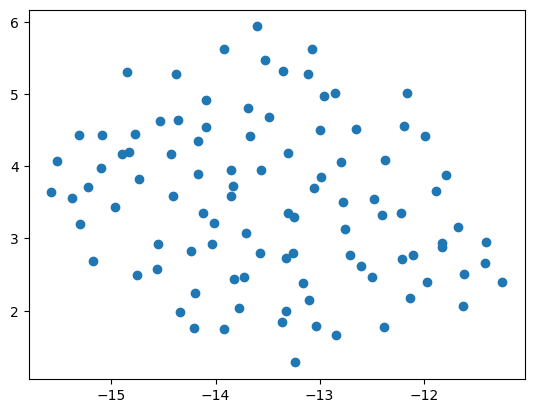

In [19]:
#import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt
w = encoder.embedding.question_embedding.weight.detach().cpu().numpy()
projector = umap.UMAP(n_components=2)
wp = projector.fit_transform(w)
plt.scatter(wp[:,0], wp[:,1])
plt.show()

# Cross validation

In [ ]:
from model.dataset import FinetuningDataset
from model.dataset import PretrainingDataset
from sklearn.model_selection import KFold
# read in data and prepare transformations
data = pd.read_csv("data/training_data/PreFer_train_data.csv", low_memory=False)
targets = pd.read_csv('data/training_data/PreFer_train_outcome.csv')
targets = targets[targets.new_child.notna()].reset_index(drop=True)
codebook = pd.read_csv('data/codebooks/PreFer_codebook.csv')

In [ ]:
n_features = 100

importance = pd.read_csv('features_importance_1000.csv')
custom_pairs = importance.iloc[:n_features].feature.map(lambda x: get_generic_name(x))
sequences = encoding_pipeline(data, codebook, custom_pairs=custom_pairs)

rnn_data = {person_id: (
        torch.tensor([year-2007 for year, _ in wave_responses.items()]).to(device),
        torch.tensor([ wave_response for _, wave_response in wave_responses.items()]).to(device)
        )
        for person_id, wave_responses in sequences.items()
}

/Users/lmmi/fertility-prediction-challenge/data_processing/pipeline.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook["pairs"] = codebook['var_name'].apply(get_generic_name)


In [ ]:
def initialize(HIDDEN_SIZE=64,
               ENCODING_SIZE=64,
               NUM_COLS=44,
               num_epochs_ft=5,
               learning_rate_ft=1e-3,
               sequences = []
               ):

    pretrain_dataset = PretrainingDataset(sequences)
    SEQ_LEN = pretrain_dataset.get_seq_len()
    VOCAB_SIZE = pretrain_dataset.get_vocab_size()

    encoder = TabularEncoder(vocab_size=VOCAB_SIZE, 
                             embedding_size=HIDDEN_SIZE, 
                             output_size=ENCODING_SIZE, 
                             num_layers=2, 
                             sequence_len=SEQ_LEN, 
                             layer_type = "excel",
                             num_cols=NUM_COLS,
                             dropout=0.1
                             ).to(device).to(device=device)

    decoder = GRUDecoder(
        input_size=ENCODING_SIZE,
        hidden_size=HIDDEN_SIZE,
        num_layers=2,
        max_seq_len=14,
        dropout=0.2,
        bidirectional=False,
        with_attention = True
    ).to(device)

    # Define loss function and optimizer for RNN
    ft_loss = nn.BCELoss()
    ft_optimizer = torch.optim.NAdam(list(decoder.parameters()) + list(encoder.parameters()) , lr=learning_rate_ft, weight_decay=1e-2, decoupled_weight_decay=True)
    ft_scheduler = optim.lr_scheduler.CosineAnnealingLR(ft_optimizer, T_max = num_epochs_ft, eta_min = 1e-6, last_epoch = -1)

    # Training loop
    decoder.train()
    encoder.train()

    return encoder, decoder, ft_optimizer, ft_loss, ft_scheduler

In [ ]:

def evaluate_and_step(loop_object, encoder, decoder, ft_scheduler, ft_loss, ft_optimizer):
    for i, batch in loop_object :        

        ft_optimizer.zero_grad() 
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        outputs = nn.functional.sigmoid(decoder(encodings, mask=mask))

        loss = ft_loss(torch.flatten(outputs), labels)  

        loss.backward()
        ft_optimizer.step()

    # On epoch end
    ft_scheduler.step()
    

In [ ]:
def evaluate(test_dataloader, encoder, decoder):
    val_loss = []
    preds = []
    targets = []

    ## Set both models into the eval mode.=
    decoder.eval()
    encoder.eval()
    for batch in test_dataloader:
        inputs, labels = batch
        labels = labels.to(torch.float).to(device)

        input_year, input_seq = inputs
        bs, ss = labels.size(0), 14
        input_year = input_year.reshape(-1).to(device)
        input_seq = input_seq.reshape(bs * ss, -1).to(device)

        encodings = encoder(input_year, input_seq).view(bs,ss, -1)
        mask = ~((input_seq == 101).sum(-1) == NUM_COLS).view(bs,ss).detach()

        # Forward pass
        xx = decoder(encodings, mask)
        outputs = torch.nn.functional.sigmoid(xx).flatten()
        loss = ft_loss(outputs, labels)  
        val_loss.append(loss.detach().cpu().numpy())
        preds.extend(outputs.detach().cpu().numpy().tolist())
        targets.extend(labels.cpu().numpy().tolist())


    # Concatenate all the batches
    predictions = (torch.tensor(preds) > 0.5).float()
    probs = F.sigmoid(predictions)
    actuals = torch.tensor(targets).flatten()

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(actuals.cpu().numpy(), predictions.cpu().numpy(), average='binary')
    map_roc = average_precision_score(actuals.numpy(), probs.numpy())
    
    return precision, recall, f1, map_roc
     


In [ ]:
HIDDEN_SIZE=64
ENCODING_SIZE=64
NUM_COLS=44
num_epochs_ft=10
learning_rate_ft=1e-3
rnn_batch_size = 10

n_splits = 4

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare for cross-validation
prec_per_fold = []
rec_per_fold = []
f1_per_fold = []
map_roc_per_fold = []

train_prec_per_fold = []
train_rec_per_fold = []
train_f1_per_fold = []
train_map_roc_per_fold = []

for fold, (train_index, val_index) in enumerate(kf.split(targets['nomem_encr'])):
    print(f'Fold: {fold}')
    train_person_ids = targets.loc[train_index, 'nomem_encr']
    test_person_ids = targets.loc[val_index, 'nomem_encr']
    
    encoder, decoder, ft_optimizer, ft_loss, ft_scheduler = initialize(
        HIDDEN_SIZE=64,
        ENCODING_SIZE=64,
        NUM_COLS=44,
        num_epochs_ft=1,
        learning_rate_ft=1e-3,
        sequences=sequences,
        )

    train_data = {person_id: rnn_data[person_id] for person_id in train_person_ids}
    test_data = {person_id: rnn_data[person_id] for person_id in test_person_ids}
    
    train_dataset = FinetuningDataset(train_data, targets = targets)
    test_dataset = FinetuningDataset(test_data, targets = targets)

    train_dataloader = DataLoader(train_dataset, batch_size=rnn_batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=rnn_batch_size)
    

    for epoch in range(num_epochs_ft):
        loop_object  = tqdm(enumerate(train_dataloader), desc=f"Epochs {epoch}")
    
        evaluate_and_step(loop_object, encoder, decoder, ft_scheduler, ft_loss, ft_optimizer)

    precision, recall, f1, map_roc = evaluate(test_dataloader, encoder, decoder)
    precision_train, recall_train, f1_train, map_roc_train = evaluate(train_dataloader, encoder, decoder)
    
    prec_per_fold.append(precision)
    rec_per_fold.append(recall)
    f1_per_fold.append(f1)
    map_roc_per_fold.append(map_roc)

    train_prec_per_fold.append(precision_train)
    train_rec_per_fold.append(recall_train)
    train_f1_per_fold.append(f1_train)
    train_map_roc_per_fold.append(map_roc_train)


Fold: 0


Epochs 0: 74it [00:14,  5.09it/s]
Epochs 1: 74it [00:09,  8.13it/s]
Epochs 2: 74it [00:09,  7.96it/s]
Epochs 3: 74it [00:09,  7.82it/s]
Epochs 4: 74it [00:09,  8.01it/s]
Epochs 5: 74it [00:09,  7.93it/s]
Epochs 6: 74it [00:09,  8.12it/s]
Epochs 7: 74it [00:09,  8.19it/s]
Epochs 8: 74it [00:08,  8.25it/s]
Epochs 9: 74it [00:08,  8.38it/s]


Fold: 1


Epochs 0: 74it [00:08,  8.30it/s]
Epochs 1: 74it [00:08,  8.26it/s]
Epochs 2: 74it [00:08,  8.33it/s]
Epochs 3: 74it [00:09,  8.14it/s]
Epochs 4: 74it [00:09,  7.91it/s]
Epochs 5: 74it [00:08,  8.26it/s]
Epochs 6: 74it [00:08,  8.25it/s]
Epochs 7: 74it [00:08,  8.37it/s]
Epochs 8: 74it [00:08,  8.31it/s]
Epochs 9: 74it [00:09,  8.01it/s]


Fold: 2


Epochs 0: 74it [00:09,  7.96it/s]
Epochs 1: 74it [00:08,  8.23it/s]
Epochs 2: 74it [00:09,  8.01it/s]
Epochs 3: 74it [00:08,  8.27it/s]
Epochs 4: 74it [00:08,  8.33it/s]
Epochs 5: 74it [00:09,  8.06it/s]
Epochs 6: 74it [00:09,  8.20it/s]
Epochs 7: 74it [00:09,  7.96it/s]
Epochs 8: 74it [00:09,  8.05it/s]
Epochs 9: 74it [00:09,  8.19it/s]


Fold: 3


Epochs 0: 75it [00:09,  8.07it/s]
Epochs 1: 75it [00:09,  8.03it/s]
Epochs 2: 75it [00:09,  8.11it/s]
Epochs 3: 75it [00:09,  8.24it/s]
Epochs 4: 75it [00:09,  8.26it/s]
Epochs 5: 75it [00:09,  8.13it/s]
Epochs 6: 75it [00:09,  8.12it/s]
Epochs 7: 75it [00:09,  8.16it/s]
Epochs 8: 75it [00:09,  8.28it/s]
Epochs 9: 75it [00:09,  8.27it/s]


In [31]:
print("Results on test set")
print("Prec:", ' '.join(f"{x:.3f}" for x in prec_per_fold))
print("Recall:", ' '.join(f"{x:.3f}" for x in rec_per_fold))
print("f1:", ' '.join(f"{x:.3f}" for x in f1_per_fold))
print("map roc:", ' '.join(f"{x:.3f}" for x in map_roc_per_fold))

Results on test set
Prec: 0.783 0.714 0.844 0.552
Recall: 0.310 0.490 0.731 0.941
f1: 0.444 0.581 0.784 0.696
map roc: 0.405 0.455 0.674 0.531


In [32]:
print('Results on training set')
print("Prec:", ' '.join(f"{x:.3f}" for x in train_prec_per_fold))
print("Recall:", ' '.join(f"{x:.3f}" for x in train_rec_per_fold))
print("f1:", ' '.join(f"{x:.3f}" for x in train_f1_per_fold))
print("map roc:", ' '.join(f"{x:.3f}" for x in train_map_roc_per_fold))

Results on training set
Prec: 0.978 0.964 0.901 0.708
Recall: 0.565 0.839 0.912 0.963
f1: 0.716 0.897 0.907 0.816
map roc: 0.643 0.844 0.841 0.689
